In [1]:
import datetime

import math
import numpy as np
import pandas as pd
import random

from scipy.signal import find_peaks

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from matplotlib.dates import MONDAY, DateFormatter, DayLocator, WeekdayLocator

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
STOCK_NAME = 'JET AIRWAYS'
STOCK_PRICE_FILE = './../database/532617.csv'

In [3]:
price_data = pd.read_csv(STOCK_PRICE_FILE,index_col = 0, parse_dates = True,
                             usecols = [u'Date',u'Open Price', u'High Price', u'Low Price', u'Close Price'],
                             dtype= {u'Open Price':np.float64,u'High Price':np.float64,
                                     u'Low Price':np.float64,u'Close Price':np.float64}).sort_index()

In [78]:
def sample_segment(dataframe, seed, sample_length=120):
    random.seed(seed)
    start_ix = random.randint(0,len(dataframe)-sample_length)
    sample_data = dataframe[start_ix:start_ix+sample_length].copy()
    return sample_data

def plot_candlestic(dataframe, stock_name):
    
    fig, ax = plt.subplots(figsize = (16,7))
    fig.subplots_adjust(bottom=0.2)

    quotes = zip(mdates.date2num(dataframe.index.to_pydatetime()),dataframe[u'Open Price'], 
                     dataframe[u'High Price'],dataframe[u'Low Price'], dataframe[u'Close Price'])
    candlestick_ohlc(ax,quotes,width=0.75,colorup='g',colordown='red',alpha=0.6)
    ax.xaxis_date()
    ax.legend([stock_name],loc='upper right', shadow=True, fancybox=True)
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.rc('axes', grid=True)
    plt.rc('grid', color='0.75', linestyle='-', linewidth=0.5)
    plt.show()

In [99]:
sample_data = sample_segment(price_data,33)

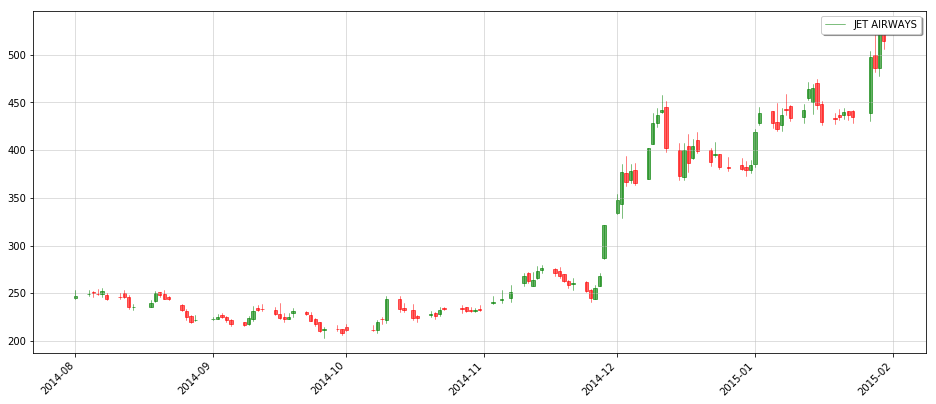

In [100]:
plot_candlestic(sample_data,STOCK_NAME)

In [85]:
def get_peaks(price_seq):
    peaks,peaks_properties = find_peaks(price_seq,distance=1,prominence=5)
    return peaks

def get_troughs(price_seq):
    price_seq_inv = price_seq*-1
    troughs,troughs_properties = find_peaks(price_seq_inv,distance=1,prominence=5)
    return troughs

def get_slope(x,y):
    dy = np.diff(y)
    dx = np.diff(x)
    slope = np.arctan(dy/dx)
    return np.insert(slope,0,0.0)    

def get_high_trend_data(dataframe):
    high_price_series = dataframe['High Price']
    high_price_seq = high_price_series.values
    peak_indices = get_peaks(high_price_seq)
    peak_prices = high_price_seq[peak_indices]
    
    high_slopes = get_slope(peak_indices,peak_prices)
    high_trend_data = pd.DataFrame(high_slopes,index = dataframe.index[peak_indices],columns=['high_slope'])
    return high_trend_data

def get_low_trend_data(dataframe):
    low_price_series = dataframe['Low Price']
    low_price_seq = low_price_series.values
    trough_indices = get_troughs(low_price_seq)
    trough_prices = low_price_seq[trough_indices]
    
    low_slopes = get_slope(trough_indices,trough_prices)
    low_trend_data = pd.DataFrame(low_slopes,index = dataframe.index[trough_indices],columns=['low_slope'])
    return low_trend_data

def get_trend_label(high_slope,low_slope):
    if math.isnan(high_slope) or math.isnan(low_slope):
        return 'indeterminate'
    elif high_slope == 0.0 and low_slope == 0:
        return 'indeterminate'
    elif high_slope > 0.0 and low_slope > 0.0:
        return 'bullish'
    elif high_slope < 0.0 and low_slope < 0.0:
        return 'bearish'
    else:
        return 'sideways'    
    
def get_trend_data(dataframe):
    high_trend_data = get_high_trend_data(dataframe)
    low_trend_data = get_low_trend_data(dataframe)
   
    trend_data = dataframe.join(high_trend_data)
    trend_data = trend_data.join(low_trend_data)
    trend_data = trend_data.fillna(method='bfill')
    
    trend_data['trend'] = trend_data.apply(lambda row: get_trend_label(row['high_slope'], row['low_slope']), axis=1)
    return trend_data

In [86]:
trend_data = get_trend_data(sample_data)
trend_data.head(10)

,Open Price,High Price,Low Price,Close Price,high_slope,low_slope,trend
Date,,,,,,,
2009-03-30,174.65,184.50,169.50,172.90,0.000000,0.000000,indeterminate
2009-03-31,168.00,175.40,158.15,169.90,0.000000,0.000000,indeterminate
2009-04-01,167.00,171.30,150.10,168.35,0.000000,0.000000,indeterminate
2009-04-02,169.00,181.95,169.00,175.25,0.000000,1.372110,sideways
2009-04-06,178.20,182.40,170.00,174.30,0.000000,1.372110,sideways
2009-04-08,167.75,217.40,165.00,209.15,0.000000,1.372110,sideways
2009-04-09,211.00,227.40,202.10,220.90,0.000000,1.429149,sideways
2009-04-13,224.00,228.70,205.55,214.45,0.000000,1.429149,sideways
2009-04-15,213.00,229.00,206.00,221.35,0.000000,1.429149,sideways


### Find higher high

In [87]:
high_trend_data = get_high_trend_data(sample_data)
latest_high = high_trend_data.iloc[-1]
high_mark_price = trend_data.loc[latest_high.name]['High Price']

In [88]:
test_data = trend_data.loc[latest_high.name:trend_data.iloc[-1].name][1:]
test_data

,Open Price,High Price,Low Price,Close Price,high_slope,low_slope,trend
Date,,,,,,,
2009-09-22,315.85,326.0,311.0,314.45,NaN,NaN,indeterminate


In [89]:
test_data[test_data['Close Price'] > high_mark_price]

,Open Price,High Price,Low Price,Close Price,high_slope,low_slope,trend
Date,,,,,,,


### Find Lower Low

In [90]:
low_trend_data = get_low_trend_data(sample_data)
latest_low = low_trend_data.iloc[-1]
low_mark_price = trend_data.loc[latest_low.name]['Low Price']

In [91]:
test_data = trend_data.loc[latest_low.name:trend_data.iloc[-1].name][1:]
test_data

,Open Price,High Price,Low Price,Close Price,high_slope,low_slope,trend
Date,,,,,,,
2009-09-09,245.00,265.8,245.00,262.55,1.337053,NaN,indeterminate
2009-09-10,260.00,264.2,251.00,253.25,1.337053,NaN,indeterminate
2009-09-11,255.00,264.5,255.00,257.40,1.337053,NaN,indeterminate
2009-09-14,261.95,270.4,261.00,263.00,1.337053,NaN,indeterminate
2009-09-15,260.00,269.2,260.00,265.20,1.337053,NaN,indeterminate
2009-09-16,268.80,269.2,265.10,267.35,1.337053,NaN,indeterminate
2009-09-17,269.50,327.8,265.35,315.60,1.337053,NaN,indeterminate
2009-09-18,312.00,333.8,308.20,318.65,1.337053,NaN,indeterminate
2009-09-22,315.85,326.0,311.00,314.45,NaN,NaN,indeterminate


In [92]:
test_data[test_data['Close Price'] < low_mark_price]

,Open Price,High Price,Low Price,Close Price,high_slope,low_slope,trend
Date,,,,,,,
